<a href="https://colab.research.google.com/github/christopher-reed/ag_data_project/blob/master/maize_development_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import packages
import pandas as pd
import numpy as np
import requests, json
import copy
import matplotlib.pyplot as plt


api_key = '70D413B2-0123-3524-9634-F730BE441009' 

#Years used in study
years = map(str,range(1981,2018))

#States used in study
states = ['IL']

#Payload for USDA Quick Stats API
payload = {'key':api_key,
          'source_desc':'SURVEY', 
           'sector_desc':'CROPS',
           'group_desc':'FIELD CROPS',
           'commodity_desc':'CORN', 
           'util_practice_desc':'ALL UTILIZATION PRACTICES', 
           'statisticcat_desc':'PROGRESS',
           'domain_desc':'TOTAL', 
           'state_alpha':states,
           'year':years,
           'format':'JSON'}

In [0]:
#Use USDA Quick Stats API to get Illinois development data

#df will contain Dented, Dough, Emerged, Mature, Planted, Silking
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
df = pd.read_json(json.dumps(r.json()),orient='split')

#Still need harvested phase so change payload to grain which will allow us to access it
payload['util_practice_desc'] = 'GRAIN'
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
dfG = pd.read_json(json.dumps(r.json()),orient='split')

#concatenate the two dataframes together because dfG contains that percent harvested while df contains all other phases
#save the raw data incase the gov't shuts down...
df = pd.concat([df,dfG])
df.to_csv('progress_data_raw.csv')

In [0]:
#Function to linearly interpolate weekly development data to daily development data.

#Load the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#List all phases of interest
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE']

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  
  #Index using the phases
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  #Convert week ending colum to datetime and set it as the index
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  #Get a list of unique years
  yrs = list(dfp.index.year.unique())
  
  #Prepare dataframe to collect specific phase data for every year
  df_specific_phase_all_years = pd.DataFrame()
  
  for y in yrs:
    
    #Make sure existing data starts with 0 and ends in 100 even when index does not extend full year yet
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
    
    #Extend index to full year
    ix = pd.date_range(start= '01-01-'+str(y), end = '12-31-'+str(y), freq = 'D')
    df_year = df_year.reindex(ix)
    
    #Make sure new extended index now starts with 0 and ends in 100
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
    
    #Linearly interpolate data
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
    
    #Concatenate new data to phase specific dataframe
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  #Concatenate all of the phase specific data
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  #Ticker for progress
  print(p)

#Name the columns
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

#Inspect dataframe
print(df_all_phases_all_years.head())

#Save as csv
df_all_phases_all_years.to_csv('illinois_development_data.csv', header = True, index = True)

PCT PLANTED
PCT SILKING
PCT DOUGH
PCT DENTED
PCT MATURE
            PCT PLANTED  PCT SILKING  PCT DOUGH  PCT DENTED  PCT MATURE
2017-01-01          0.0          0.0        0.0         0.0         0.0
2017-01-02          0.0          0.0        0.0         0.0         0.0
2017-01-03          0.0          0.0        0.0         0.0         0.0
2017-01-04          0.0          0.0        0.0         0.0         0.0
2017-01-05          0.0          0.0        0.0         0.0         0.0


Text(0, 0.5, 'Percent Crop')

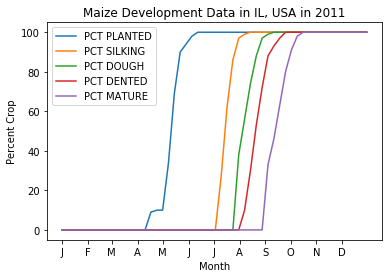

In [0]:
#Development data currently assumes that once the entire crop has reached a 
#development stage it stays at 100% complete

df_development = copy.deepcopy(df_all_phases_all_years.loc['2011-01-01':'2011-12-31'])

for i in df_all_phases_all_years.columns:
  x = df_development.index
  y = df_development[i]
  plt.plot(x,y, label = i)


locs = ['2011-01-01','2011-02-01','2011-03-01','2011-04-01','2011-05-01','2011-06-01',
        '2011-07-01','2011-08-01','2011-09-01','2011-10-01','2011-11-01','2011-12-01']
labels = ['J','F','M','A','M','J','J','A','S','O','N','D']

plt.xticks(locs, labels)
plt.legend()
plt.title('Maize Development Data in IL, USA in 2011')
plt.xlabel('Month')
plt.ylabel('Percent Crop')
  

In [0]:
#Adjust development data so there is a smooth transition between phases

#Read in data if have not done so already
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['1981-01-01':'2017-12-31']


df['vegetative'] = df['PCT PLANTED'] - df['PCT SILKING']
df['early_grain'] = df['PCT SILKING'] - df['PCT DOUGH']
df['late_grain'] = df['PCT DOUGH'] - df['PCT MATURE']

#Add a sum column to verify result.
df['sum'] = df['vegetative'] + df['early_grain'] + df['late_grain'] 

df_combined= df[['vegetative', 'early_grain', 'late_grain', 'sum']]

#Save result as csv
df_combined.to_csv('illinois_combined_development_data.csv', index = True, header = True)

Text(0, 0.5, 'Percent Crop')

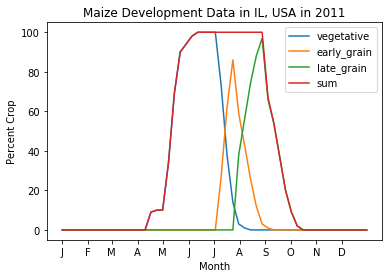

In [0]:
#Visualize new development data

df_development = copy.deepcopy(df_combined.loc['2011-01-01':'2011-12-31'])

for i in df_development.columns:
  x = df_development.index
  y = df_development[i]
  plt.plot(x,y, label = i)
  
locs = ['2011-01-01','2011-02-01','2011-03-01','2011-04-01','2011-05-01','2011-06-01',
        '2011-07-01','2011-08-01','2011-09-01','2011-10-01','2011-11-01','2011-12-01']
labels = ['J','F','M','A','M','J','J','A','S','O','N','D']

plt.xticks(locs, labels)
plt.legend()
plt.title('Maize Development Data in IL, USA in 2011')
plt.xlabel('Month')
plt.ylabel('Percent Crop')